<p style="background-color:#000000;font-family:newtimeroman;color:#AFEEEE;font-size:300%;text-align:center;border-radius:50px 60px;">BookGenie: Book Genre Prediction</p>


<p style="font-family:newtimeroman;color:#000000;font-size:200%;text-align:left;">Kelompok 22:</p>

<ul style="font-family:newtimeroman;color:#000000;font-size:150%;text-align:left;">
  <li>Rana Rahmat Hidayat</li>
  <li>Edwinpras Wijaya</li>
  <li>Fariz Dwiki</li>
  <li>Helga Puspita</li>
  <li>Siti Nurhayati</li>
</ul>


<a id="libraries"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Importing Essential libraries for NLP</p>

Pada tahap awal ini, kita akan mengimpor berbagai pustaka yang esensial untuk pemrosesan bahasa alami (Natural Language Processing/NLP). Pustaka-pustaka tersebut termasuk pandas untuk manipulasi data, numpy untuk operasi numerik, matplotlib dan seaborn untuk visualisasi data, serta pustaka NLP seperti nltk, spaCy, dan scikit-learn.

In [2]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

import re
import string
from wordcloud import WordCloud
from collections import Counter

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

<a id="data"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Importing Data</p>

Selanjutnya, kita akan mengimpor dataset yang akan digunakan dalam analisis ini. Dataset ini dapat berupa file CSV, Excel, atau format lain yang didukung oleh pandas. Proses ini melibatkan pembacaan file dan menyimpannya dalam bentuk DataFrame untuk memudahkan manipulasi dan analisis lebih lanjut.

In [3]:
# Loading the required data
data=pd.read_csv('/content/book_genre.csv',index_col='index')
data.head()

,title,genre,summary
index,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4657 entries, 0 to 4656
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4657 non-null   object
 1   genre    4657 non-null   object
 2   summary  4657 non-null   object
dtypes: object(3)
memory usage: 145.5+ KB


<a id="de"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Data Exploration</p>

Setelah mengimpor data, kita akan melakukan eksplorasi data untuk memahami struktur dan karakteristiknya. Ini meliputi pemeriksaan jumlah baris dan kolom, tipe data setiap kolom, nilai-nilai yang hilang, serta statistik deskriptif dasar. Langkah ini penting untuk mendapatkan wawasan awal tentang data yang kita miliki.

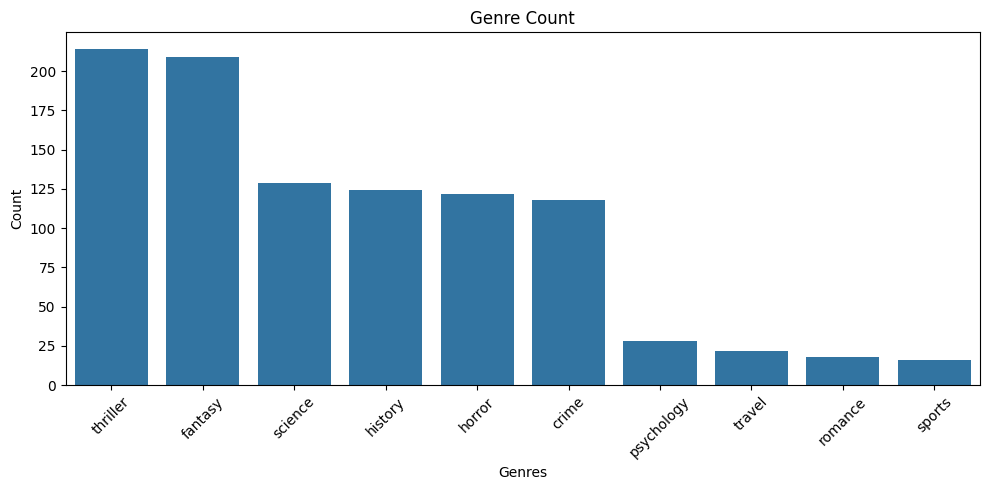

In [5]:
# Subsampling data
sampled_data = data.sample(n=1000, random_state=42)  # Ubah angka 1000 sesuai kebutuhan

# Menghitung jumlah masing-masing kategori genre
genre_counts = sampled_data['genre'].value_counts()

# Mengurutkan kategori berdasarkan jumlahnya
genre_counts_sorted = genre_counts.sort_values(ascending=False)

# Membuat plot
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts_sorted.index, y=genre_counts_sorted)
plt.title('Genre Count')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Mengatur rotasi label sumbu x agar lebih mudah dibaca
plt.tight_layout()  # Mengoptimalkan tata letak plot
plt.show()

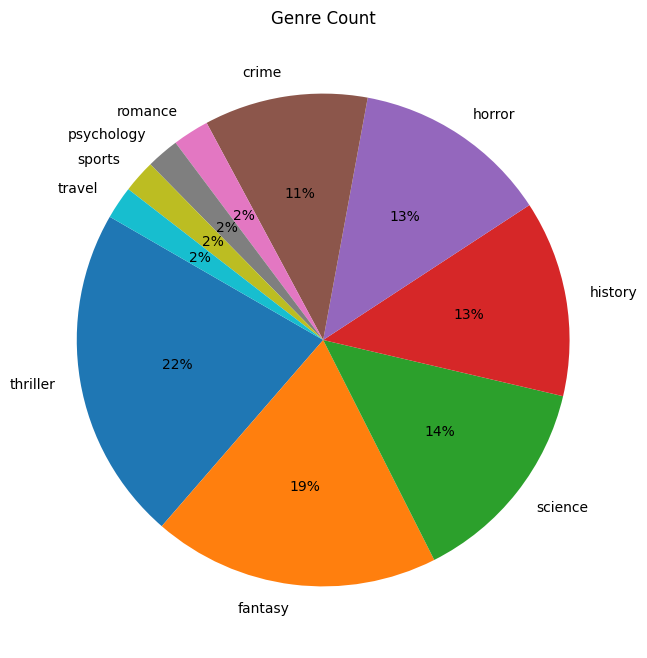

In [6]:
# Membuat pie chart untuk label target
plt.figure(figsize=(10,8))
plt.pie(x=data['genre'].value_counts(),labels=data['genre'].value_counts().index,textprops={'fontsize':10},startangle=150,autopct='%1.0f%%')
plt.title('Genre Count');

In [7]:
# Fungsi replace_values di bawah digunakan untuk mengganti nilai pada kolom genre berdasarkan kriteria yang telah kami ditentukan
def replace_values(x):
    if x == 'crime':
        return 'crime'
    elif x == 'romance':
        return 'romance'
    elif x == 'thriller' or x == 'horror':
        return 'thriller'
    elif x == 'psychology' or x == 'science' or x == 'history':
        return 'learning'
    elif x == 'fantasy':
        return 'fantasy'
    elif x == 'travel' or x == 'sports':
        return 'adventure'
    else:
        return x

data['genre'] = data['genre'].apply(replace_values)

# Menghitung jumlah judul setiap genre
data['genre'].value_counts()

genre
thriller     1623
learning     1347
fantasy       876
crime         500
adventure     200
romance       111
Name: count, dtype: int64

<a id="fe"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Feature Engineering</p>

Pada tahap ini, kita akan menciptakan fitur-fitur baru yang dapat membantu dalam model prediksi. Feature engineering meliputi transformasi data yang ada atau penambahan kolom baru berdasarkan data yang ada, yang dapat meningkatkan kinerja model machine learning yang akan dibangun.

- panjang_judul
- panjang_karakter_judul
- panjang_ringkasan
- panjang_karakter_ringkasan

In [8]:
# Membuat kolom panjang_judul
data['panjang_kata_judul']=data['title'].apply(lambda x:len(x.split()))
data.head()

,title,genre,summary,panjang_kata_judul
index,,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,2
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",3
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,5
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,2
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,2


In [9]:
# Fungsi di bawah ini praktis untuk menghitung jumlah karakter dalam teks
def char_count(text):
    charc=0
    for char in text.split():
        charc +=len(char)
    return charc

# Membuat kolom panjang_judul
data['panjang_huruf_judul']=data['title'].apply(char_count)

In [10]:
data.head()

,title,genre,summary,panjang_kata_judul,panjang_huruf_judul
index,,,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,2,16
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",3,11
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,5,21
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,2,14
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,2,13


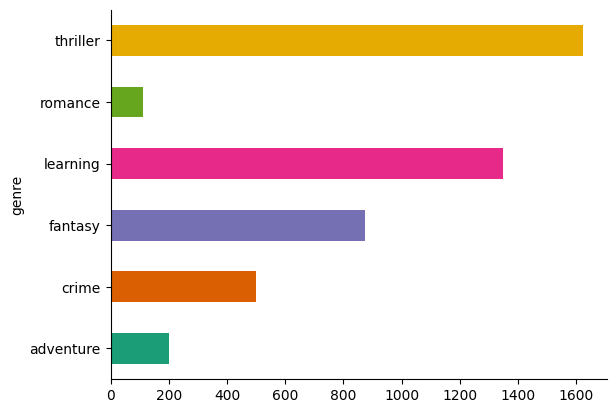

In [11]:
# Judul genre
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('genre').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

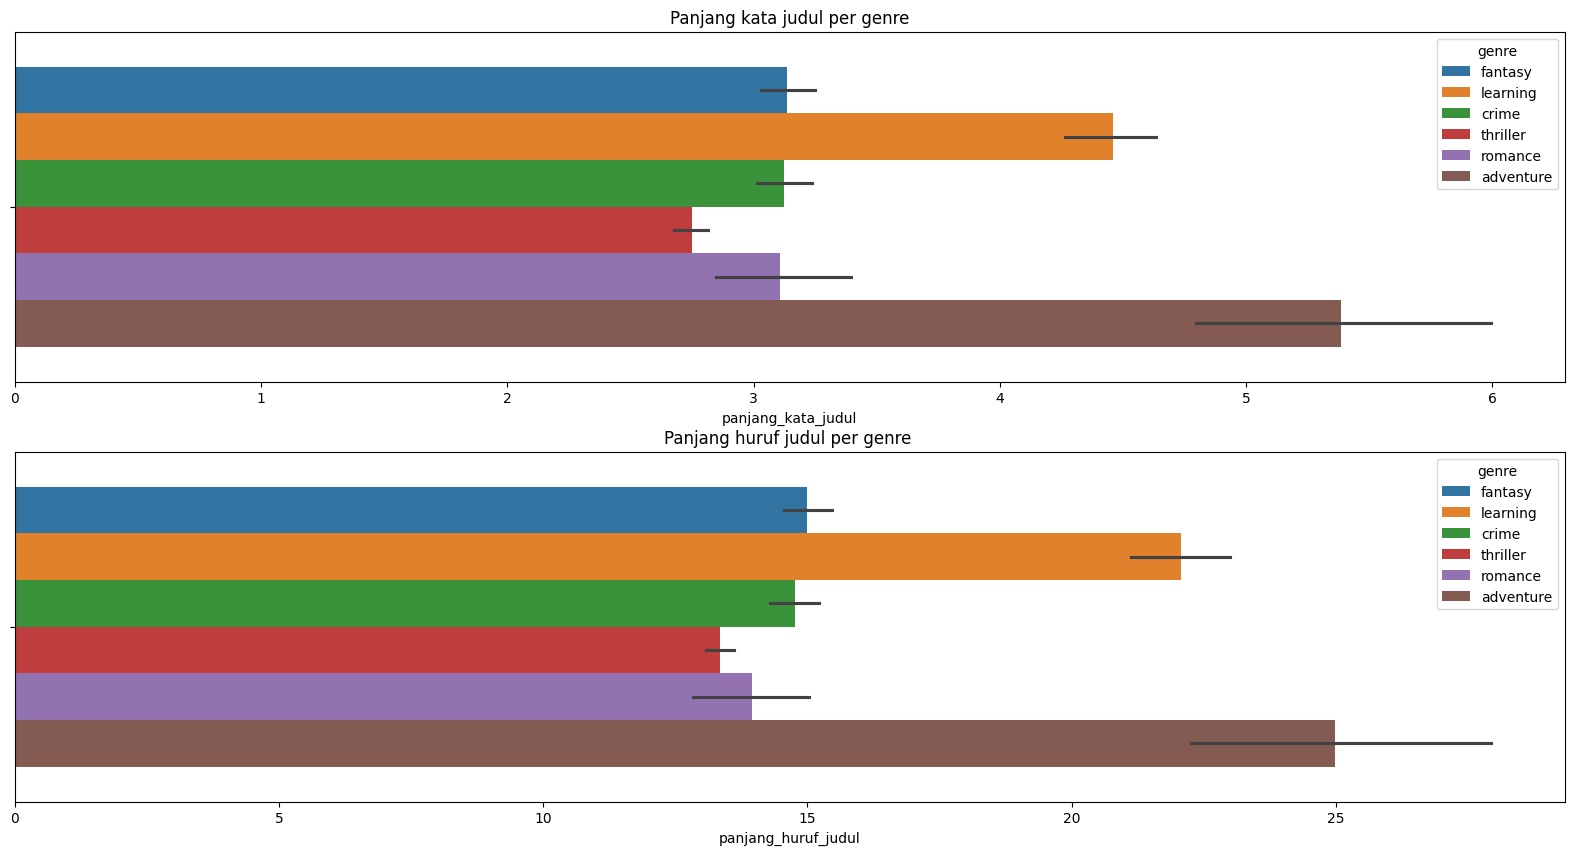

In [12]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.barplot(x=data['panjang_kata_judul'], hue=data['genre'], fill=True)
plt.title('Panjang kata judul per genre')

plt.subplot(2,1,2)
sns.barplot(x=data['panjang_huruf_judul'], hue=data['genre'], fill=True)
plt.title('Panjang huruf judul per genre ')

plt.show()

In [13]:
# Membuat kolom panjang_ringkasan dan panjang_huruf_ringkasan
data['panjang_kata_ringkasan']=data['summary'].apply(lambda x:len(x.split()))
data['panjang_huruf_ringkasan']=data['summary'].apply(char_count)

data.head()

,title,genre,summary,panjang_kata_judul,panjang_huruf_judul,panjang_kata_ringkasan,panjang_huruf_ringkasan
index,,,,,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,2,16,803,3901
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",3,11,563,2564
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,5,21,334,1619
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,2,14,776,3822
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,2,13,1190,5553


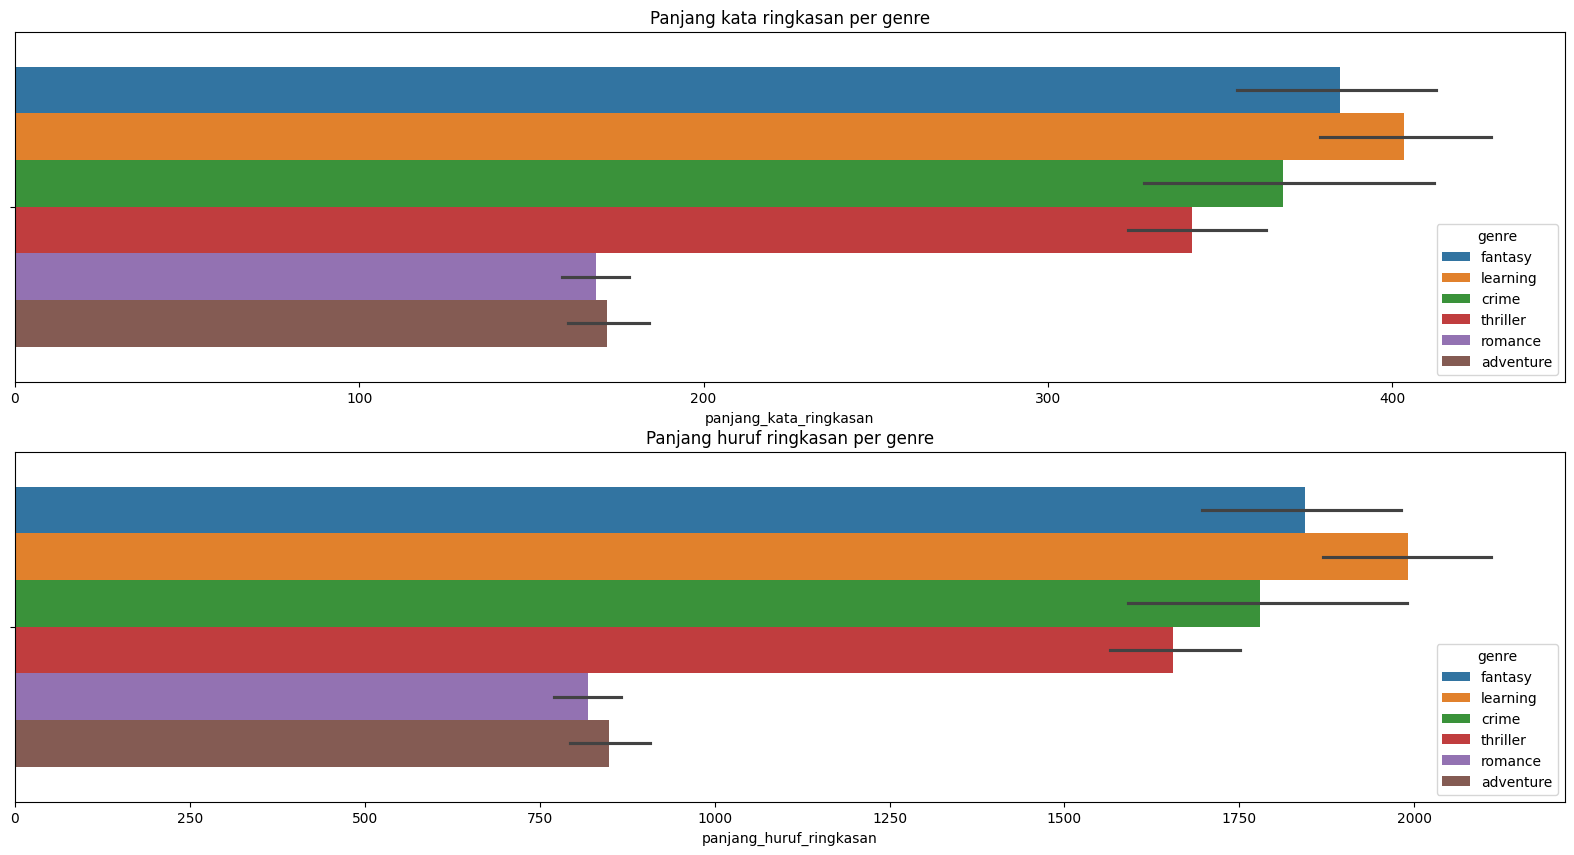

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.barplot(x=data['panjang_kata_ringkasan'], hue=data['genre'], fill=True)
plt.title('Panjang kata ringkasan per genre')

plt.subplot(2,1,2)
sns.barplot(x=data['panjang_huruf_ringkasan'], hue=data['genre'], fill=True)
plt.title('Panjang huruf ringkasan per genre')

plt.show()

In [15]:
data.groupby('genre')[['panjang_kata_judul','panjang_huruf_judul']].describe().T

genre                       adventure       crime     fantasy     learning  \
panjang_kata_judul  count  200.000000  500.000000  876.000000  1347.000000   
                    mean     5.385000    3.122000    3.135845     4.458797   
                    std      4.434535    1.327645    1.674288     3.573726   
                    min      1.000000    1.000000    1.000000     1.000000   
                    25%      2.000000    2.000000    2.000000     2.000000   
                    50%      4.000000    3.000000    3.000000     3.000000   
                    75%      7.250000    4.000000    4.000000     5.000000   
                    max     28.000000    9.000000   13.000000    26.000000   
panjang_huruf_judul count  200.000000  500.000000  876.000000  1347.000000   
                    mean    24.995000   14.762000   14.993151    22.077209   
                    std     21.667542    5.329368    6.974563    17.259405   
                    min      2.000000    5.000000    3.000000     3.000000   
                    25%     11.000000   11.000000   11.000000    12.000000   
                    50%     16.500000   14.000000   14.000000    16.000000   
                    75%     35.250000   18.000000   18.000000    23.000000   
                    max    139.000000   54.000000   58.000000   122.000000   

genre                         romance     thriller  
panjang_kata_judul  count  111.000000  1623.000000  
                    mean     3.108108     2.747998  
                    std      1.497582     1.416377  
                    min      1.000000     1.000000  
                    25%      2.000000     2.000000  
                    50%      3.000000     3.000000  
                    75%      4.000000     3.000000  
                    max      7.000000     9.000000  
panjang_huruf_judul count  111.000000  1623.000000  
                    mean    13.954955    13.337646  
                    std      5.748340     5.819149  
                    min      5.000000     2.000000  
                    25%      9.000000     9.000000  
                    50%     14.000000    13.000000  
                    75%     17.000000    16.000000  
                    max     34.000000    52.000000

In [16]:
# Menggabungkan judul dan ringkasan untuk prapemrosesan teks lebih lanjut
data['Combined_Text']=data['title'] + ' ' + data['summary']
data.head()

,title,genre,summary,panjang_kata_judul,panjang_huruf_judul,panjang_kata_ringkasan,panjang_huruf_ringkasan,Combined_Text
index,,,,,,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,2,16,803,3901,Drowned Wednesday Drowned Wednesday is the fi...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",3,11,563,2564,"The Lost Hero As the book opens, Jason awaken..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,5,21,334,1619,The Eyes of the Overworld Cugel is easily per...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,2,14,776,3822,Magic's Promise The book opens with Herald-Ma...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,2,13,1190,5553,Taran Wanderer Taran and Gurgi have returned ...


<a id="tp"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Text Preprocessing</p>


Persiapan teks untuk analisis NLP, karena kita tahu bahwa sulit bagi komputer untuk memahami semantik teks dalam bentuk murninya, maka menjadi penting untuk memproses data agar dapat diubah menjadi bentuk yang bisa dimasukkan ke dalam komputer untuk dianalisis.

Di sini, kita akan mengubah data teks sebagai berikut:

- Mengubah Menjadi Huruf Kecil (Convert to Lowercase)
- Menghapus Tanda Baca (Remove punctuations)
- Menghapus Kata - Kata yang tidak diperlukan (Remove stopwords)
- Stemming dan Lemmatisai adalah teknik prapemrosesan teks yang digunakan untuk mengurangi kata-kata menjadi bentuk dasar mereka. Stemming biasanya memotong akhiran dari kata untuk mengurangi ke bentuk dasarnya, sedangkan lemmatization menggunakan kamus dan aturan linguistik untuk mengurangi kata-kata ke bentuk dasarnya. (Stemming/Lemmatization)

In [17]:
# Berfungsi untuk mengonversi teks gabungan menjadi huruf kecil
def lowercase(text):
    text=text.lower()
    return text

In [18]:
# Berfungsi untuk menghapus tanda baca dari teks gabungan
punc=string.punctuation

def removepunc(text):
    return text.translate(str.maketrans('','',punc))

In [19]:
# Bahkan setelah operasi sebelumnya pada teks, teks tersebut masih mengandung banyak kata yang tidak menambahkan konteks apa pun pada pemrosesan bahasa di NLP yang dikenal sebagai stopwords.
# Oleh karena itu, perlu untuk menyaring stopwords ini dari teks yang diperlukan menggunakan fungsi di bawah ini:
def remove_sw(text):
    new_list=[]
    # Tokenisasi adalah memecah data yang kompleks menjadi unit-unit yang lebih kecil yang disebut token. Hal ini dapat dilakukan dengan memecah paragraf menjadi kalimat dan kalimat menjadi kata.
    words=word_tokenize(text)
    sws=stopwords.words('english')
    for word in words:
        if word not in sws:
            new_list.append(word)

    return ' '.join(new_list)

In [20]:
# Berfungsi untuk melakukan stemming pada teks gabungan
def stem_text(text):
    new_list=[]
    stemmer=PorterStemmer()
    words=word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return ' '.join(new_list)

In [21]:
import nltk

# Unduh sumber daya NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')

# Dengan mengasumsikan fungsi yang lain (lowercase, remove_unc, remove_sw, stem_text) sudah didefinisikan

# Menerapkan fungsi pemrosesan teks
data['Combined_Text'] = data['Combined_Text'].apply(lowercase)
data['Combined_Text'] = data['Combined_Text'].apply(removepunc)
data['Combined_Text'] = data['Combined_Text'].apply(remove_sw)
data['Combined_Text'] = data['Combined_Text'].apply(stem_text)

data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,genre,summary,panjang_kata_judul,panjang_huruf_judul,panjang_kata_ringkasan,panjang_huruf_ringkasan,Combined_Text
index,,,,,,,,
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,2,16,803,3901,drown wednesday drown wednesday first truste a...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...",3,11,563,2564,lost hero book open jason awaken school bu una...
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,5,21,334,1619,eye overworld cugel easili persuad merchant fi...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,2,14,776,3822,magic promis book open heraldmag vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...,2,13,1190,5553,taran wander taran gurgi return caer dallben f...


<a id="wordcloud"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Wordcloud</p>


Dalam bagian ini, kita akan membuat wordcloud untuk memvisualisasikan kata-kata yang paling sering muncul dalam teks. Wordcloud memberikan representasi grafis dari frekuensi kata, di mana ukuran kata dalam cloud menunjukkan seberapa sering kata tersebut muncul dalam dataset. Misalkan, disini kita ambil contoh dari 2 genre yaitu fantasy dan thriller.

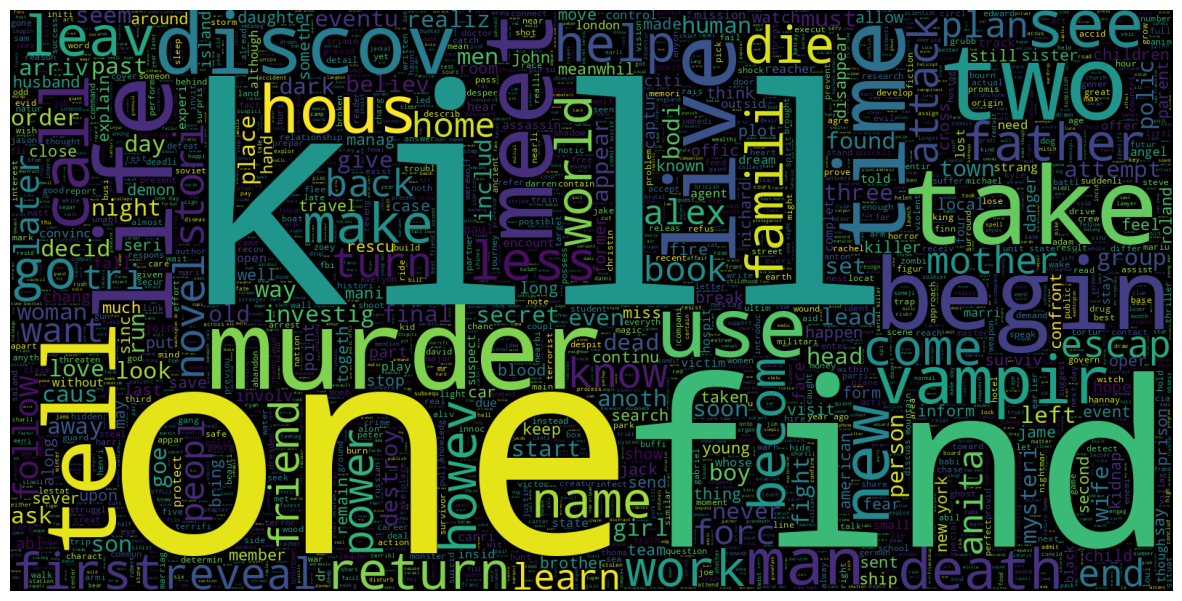

In [22]:
text=' '.join(data[data['genre']=='thriller']['Combined_Text'])
plt.figure(figsize=(15,10))
wordcloud=WordCloud(max_words=5000,height=800,width=1600,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<a id="le"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Label Encoding</p>

Untuk mengonversi label atau kategori ke dalam format numerik yang dapat digunakan oleh algoritma machine learning, kita akan melakukan label encoding. Proses ini mengubah label teks menjadi angka, yang membuatnya kompatibel dengan model machine learning.

In [23]:
# Importing LabelEncoder from scikit learn library
from sklearn.preprocessing import LabelEncoder

# Pengkodean kolom genre
encoder=LabelEncoder()
data['genre_encoder']=encoder.fit_transform(data['genre'])

unique_genres = data['genre'].unique()
unique_encodings = data['genre_encoder'].unique()

genre_mapping = pd.DataFrame({
    'genre': unique_genres,
    'genre_encoder': unique_encodings
})

In [24]:
genre_mapping

,genre,genre_encoder
0,fantasy,2
1,learning,3
2,crime,1
3,thriller,5
4,romance,4
5,adventure,0


<a id="tv"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Text Vectorization</p>

Mengubah teks menjadi representasi numerik yang dapat dimengerti oleh model, seperti TF-IDF, TF-IDF dalam NLP merupakan singkatan dari Term Frequency – Inverse Document Frequency. Dalam NLP, data yang telah dibersihkan perlu diubah menjadi format numerik di mana setiap kata direpresentasikan oleh sebuah matriks.
Term Frequency (TF) = (Frekuensi sebuah kata dalam dokumen)/(Total jumlah kata dalam dokumen) Inverse Document Frequency (IDF) = log( (total jumlah dokumen)/(jumlah dokumen dengan kata t)).

In [25]:
# Memisahkan data menjadi fitur (X) dan target (y)
X=data['Combined_Text']
y=data['genre_encoder'].values

In [26]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets to use in models
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size= 0.2, random_state= 42,stratify=y)

In [27]:
# penyimpanan X_train ke dalam file.csv
# Mengonversi X_train menjadi DataFrame untuk memudahkan penyimpanan
X_train_data = pd.DataFrame(X_train, columns=['Combined_Text'])

# Menyimpan DataFrame ke file CSV
# Menyimpan DataFrame ke file CSV
X_train_data.to_csv('X_train_tfidf.csv', index=False)

print("Data berhasil disimpan ke file CSV")

Data berhasil disimpan ke file CSV


In [28]:
tfidf=TfidfVectorizer()
X_train=tfidf.fit_transform(X_train).toarray()
X_test=tfidf.transform(X_test).toarray()

<a id="test"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Training the Model</p>

Model dalam pelatihan yang kita gunakan, antara lain:

1. **Support Vector Machines (SVM)**:
   - SVM dapat menangani ruang fitur yang besar dan memiliki kemampuan untuk memisahkan data dengan margin yang jelas, yang penting dalam klasifikasi yang kompleks seperti genre buku.

2. **Decision Tree**:
   - Decision Tree dipilih karena mudah diinterpretasikan dan dapat menangani baik data numerik maupun kategorikal. Decision Tree juga cenderung tidak terpengaruh oleh adanya skewness pada data dan tidak memerlukan skala data yang seragam.

3. **Random Forest**:
   - Kami memilih Random Forest karena kemampuannya untuk mengurangi overfitting dibandingkan dengan Decision Tree tunggal. Random Forest dapat meningkatkan keakuratan dan kestabilan model, yang berguna untuk dataset yang kompleks.

4. **Gradient Boosting Machine (GBM)**:
   - GBM dipilih karena kemampuannya untuk membangun model yang sangat akurat. GBM secara iteratif memperbaiki kelemahan model lain, yang membuatnya sangat efektif dalam memprediksi genre buku berdasarkan fitur-fitur teks yang rumit.

5. **KNeighborsClassifier (KNN)**:
   - KNN dipilih karena sifatnya yang sederhana namun efektif. KNN memanfaatkan keterdekatannya dengan data latih untuk membuat prediksi, yang cocok untuk dataset dengan cluster atau grup alami, seperti kategori genre buku.

In [29]:
def train_model(model, X_train, X_test, y_train, y_test):
    # Melatih model
    model.fit(X_train, y_train)

    # Memprediksi dengan model yang telah dilatih
    y_pred = model.predict(X_test)

    # Evaluasi model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Mencetak hasil evaluasi
    print("Accuracy of the model: ", accuracy)
    print("Precision Score of the model: ", precision)
    print("Recall Score of the model: ", recall)
    print("F1 Score of the model: ", f1)

    return accuracy, precision, recall, f1

# Daftar model yang akan diuji
models = {
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Machine": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

# Melatih
for model_name, model in models.items():
    print(f"Training {model_name}...")
    train_model(model, X_train, X_test, y_train, y_test)
    print("\n")

Training SVM...
Accuracy of the model:  0.7274678111587983
Precision Score of the model:  0.7453829087407337
Recall Score of the model:  0.7274678111587983
F1 Score of the model:  0.700045557051536


Training Decision Tree...
Accuracy of the model:  0.5032188841201717
Precision Score of the model:  0.4998129626490231
Recall Score of the model:  0.5032188841201717
F1 Score of the model:  0.5010758518886773


Training Random Forest...
Accuracy of the model:  0.6673819742489271
Precision Score of the model:  0.70587946704085
Recall Score of the model:  0.6673819742489271
F1 Score of the model:  0.6304119473100981


Training Gradient Boosting Machine...
Accuracy of the model:  0.6866952789699571
Precision Score of the model:  0.6924798139973004
Recall Score of the model:  0.6866952789699571
F1 Score of the model:  0.6772539544582635


Training KNN...
Accuracy of the model:  0.6512875536480687
Precision Score of the model:  0.6598158026403244
Recall Score of the model:  0.6512875536480687
F

Pada tahap ini, kami mencoba melakukan testing akurasi parameter grid untuk meningkatkan akurasi saat digunakan pemorediksian. Kami menggunakan Model Support Vector Machines (SVM) yang mendapatkan hasil akurasi yang paling tinggi diantara 5 model yang telah kami coba latih dan uji sebelumnya.

In [30]:
# Parameter grid untuk SVM
param_grid_svm = {
    'C': [1, 10],           # Hanya dua nilai untuk C
    'gamma': [0.1, 0.01],   # Hanya dua nilai untuk gamma
    'kernel': ['rbf']       # Hanya satu jenis kernel
}

# Inisialisasi GridSearchCV untuk SVM
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=2, cv=5)

# Melakukan pencarian grid pada data training
grid_svm.fit(X_train, y_train)

# Menampilkan parameter terbaik untuk SVM
print("Best parameters for SVM: ", grid_svm.best_params_)

# Mengevaluasi model terbaik untuk SVM pada data test
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
print("SVM Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("SVM Classification report:\n", classification_report(y_test, y_pred_svm))

# Model best ini disimpan dan yang akan digunakan selanjutnya, karena asumsinya ini yang terbaik

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=10.6min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=10.5min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=10.4min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=10.6min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=10.5min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=10.3min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=10.4min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=10.3min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=10.5min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=10.7min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=11.6min
[CV] END ........................C=10, gamma=0.1,

<a id="evaluation"></a>
# <p style="background-color:#AFEEEE;font-family:newtimeroman;color:#000000;font-size:120%;text-align:center;border-radius:50px 60px;">Evaluation Model</p>


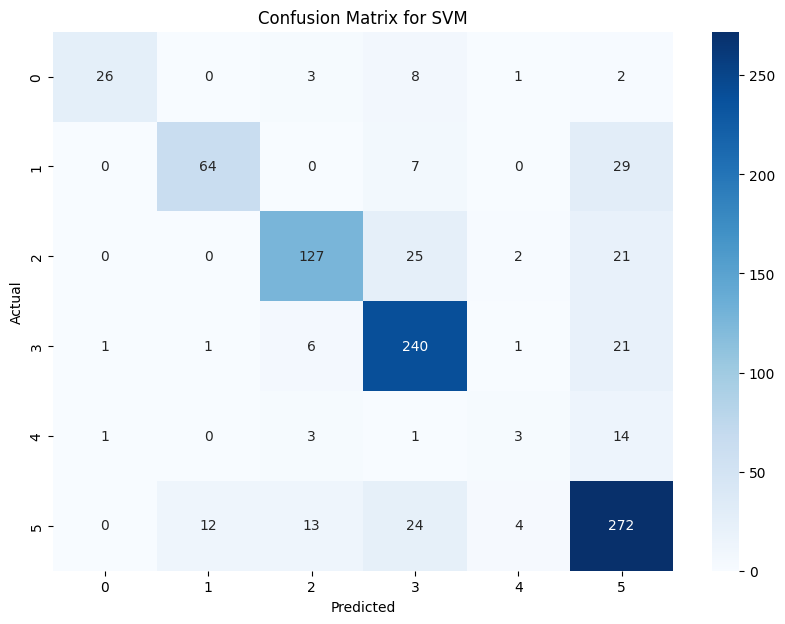

In [31]:
# Evaluasi plot confusion matrix untuk SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Implementasi ke Website menggunakan Streamlit (berbasis python)

*   Menyimpan Model Support Vector Machine ke dalam bentuk File dengan extension (.pkl) dengan tujuan agar bisa digunakan didalam WEBSITE



In [38]:
# Inisialisasi dan melatih model SVM dengan parameter terbaik
seed = 42
svm = SVC(C=10, gamma=0.1, kernel='rbf', random_state=seed)
svm.fit(X_train_tfidf, y_train)

# Menyimpan model ke dalam file dengan ekstensi .pkl menggunakan library pickle
model_file_name = "svm_model.pkl"
with open(model_file_name, 'wb') as model_file:
    pickle.dump(svm, model_file)
print("Model saved as", model_file_name)

# Menyimpan TfidfVectorizer ke dalam file dengan ekstensi .pkl menggunakan library pickle
vectorizer_file_name = "tfidf_vectorizer.pkl"
with open(vectorizer_file_name, 'wb') as file:
    pickle.dump(tfidf, file)
print("Vectorizer saved as", vectorizer_file_name)

print('\nModel dan vektorizer ini akan digunakan di dalam website sebagai model prediksi genre buku')

Model saved as svm_model.pkl
Vectorizer saved as tfidf_vectorizer.pkl

Model dan vektorizer ini akan digunakan di dalam website sebagai model prediksi genre buku


*   Cara memanggil file .pkl yang sudah dibuat di WEBSITE jika ingin digunakan

In [43]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Load Model
with open("/content/svm_model.pkl", 'rb') as file:
    loaded_model = pickle.load(file)

with open("/content/tfidf_vectorizer.pkl", 'rb') as file:
    tfidf = pickle.load(file)


# Data input untuk prediksi
book_description = ["till death"]  # Ubah dengan deskripsi buku Anda

# Menerapkan fungsi pemrosesan teks pada deskripsi buku
book_description_processed = [stem_text(remove_sw(removepunc(lowercase(text)))) for text in book_description]

# Membaca data X_train
X_train = pd.read_csv('/content/X_train_tfidf.csv')  # Ubah sesuai dengan lokasi yang benar

# Menerapkan pemrosesan teks pada data X_train
X_train['Combined_Text'] = X_train['Combined_Text'].apply(lowercase)
X_train['Combined_Text'] = X_train['Combined_Text'].apply(removepunc)
X_train['Combined_Text'] = X_train['Combined_Text'].apply(remove_sw)
X_train['Combined_Text'] = X_train['Combined_Text'].apply(stem_text)

# Membuat dan melatih tfidf vectorizer dari data X_train
tfidf = TfidfVectorizer(max_features=40333)  # Atur max_features sesuai kebutuhan
X_train_tfidf = tfidf.fit_transform(X_train['Combined_Text']).toarray()

# Transformasi deskripsi buku menggunakan TfidfVectorizer yang sama
book_description_tfidf = tfidf.transform(book_description_processed).toarray()

# Prediksi genre buku
predictions = loaded_model.predict(book_description_tfidf)

# Menerjemahkan hasil prediksi ke genre yang sesuai
genre_mapping = {0: "adventure", 1: "crime", 2: "fantasy", 3: "learning", 4: "romance", 5: "thriller"}  # Sesuaikan dengan label genre Anda

predicted_genre = genre_mapping[predictions[0]]

print('Prediksi Genre:', predicted_genre)


Prediksi Genre: thriller
